<center><h1>Generating and saving Edge Detections as Priviledged ifnormation for Object Detection</h1>
<h2>Matthias Bartolo</h2>

</center>

<h3>Generating the Edge Detection Images and Saving</h3>

In [1]:
import os
import cv2

def generate_edge_detection_images(yolo_dataset_path, output_base_path, low_threshold=100, high_threshold=200):
    """
    Generate and save edge detection images using Canny for YOLO dataset.
    
    Args:
        yolo_dataset_path (str): Path to the dataset with train, test, valid folders.
        output_base_path (str): Path to save the edge detection images.
        low_threshold (int): Lower threshold for Canny edge detection.
        high_threshold (int): Upper threshold for Canny edge detection.
    """
    for subset in ["train", "test", "valid"]:
        input_folder = os.path.join(yolo_dataset_path, subset, "images")  # Adjusted for 'images' subfolder
        output_folder = os.path.join(output_base_path, subset, "edge_images")  # Save edge images in a new folder

        # Create the output folder if it doesn't exist
        os.makedirs(output_folder, exist_ok=True)
        
        for image_file in os.listdir(input_folder):
            # Process only image files
            if image_file.endswith(('.jpg', '.png', '.jpeg')):
                image_path = os.path.join(input_folder, image_file)
                output_image_path = os.path.join(output_folder, image_file)
                
                # Read the image
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    print(f"Could not read image {image_path}")
                    continue
                
                # Apply Canny edge detection
                edges = cv2.Canny(image, low_threshold, high_threshold)
                
                # Save the processed image
                cv2.imwrite(output_image_path, edges)
                print(f"Saved edge-detection image to {output_image_path}")

# Paths
yolo_dataset_path = "datasets/Zoo-Animals-2/"  # Base path for your YOLO dataset
output_base_path = "datasets/Zoo-Animals-2/"   # Base path for saving edge-detection images

# Generate edge-detection images
generate_edge_detection_images(yolo_dataset_path, output_base_path)


Saved edge-detection image to datasets/Zoo-Animals-2/train\edge_images\0005d2ea-bc64-4d9f-b46c-f2d535fceccf_jpg.rf.6fcda4d582931403b580be895fbb4b82.jpg
Saved edge-detection image to datasets/Zoo-Animals-2/train\edge_images\000985b1-1e80-4e25-a86a-8c4d164dd770_jpg.rf.9122957012d1cd0fae75e5fc62a389aa.jpg
Saved edge-detection image to datasets/Zoo-Animals-2/train\edge_images\001b3c03-9536-4fb0-a125-963c0bd5a534_jpg.rf.9d08d559fa960ec42b700ab6d39c55eb.jpg
Saved edge-detection image to datasets/Zoo-Animals-2/train\edge_images\001da724-0cc9-49d6-adcc-2c03ae9473e2_jpg.rf.260ae8934c573ae411ccbd8b9ec3e6ac.jpg
Saved edge-detection image to datasets/Zoo-Animals-2/train\edge_images\0059d502-7f73-46b3-bdc1-0a796028d4c0_jpg.rf.88600da74c23c48d5b55790365f36ed6.jpg
Saved edge-detection image to datasets/Zoo-Animals-2/train\edge_images\005b7503-886b-4a82-b5e0-825d1e5b22ea_jpg.rf.5293fa5b0280fb625ee333c563764216.jpg
Saved edge-detection image to datasets/Zoo-Animals-2/train\edge_images\0078b18d-c023-4b8

<h3>Compressing the both the RGB images to include the Edge Detections, so to be in 4 channels</h3>
To do this, image needs to be save through rasterio and in .tif format. This is because the .tif format allows for multiple channels to be saved in the same file. The edge detection images are saved in the 4th channel of the .tif file.

```python
pip install rasterio
```

In [1]:
import os
import rasterio
import numpy as np
from PIL import Image
from rasterio.enums import Resampling

def combine_rgb_and_edges(rgb_folder, edge_folder, output_folder):
    """
    Combine RGB images with edge-detection images to create 4-channel input.
    Args:
        rgb_folder (str): Path to folder containing RGB images.
        edge_folder (str): Path to folder containing edge-detection images.
        output_folder (str): Path to save the 4-channel images.
    """
    os.makedirs(output_folder, exist_ok=True)
    
    for image_file in os.listdir(rgb_folder):
        if image_file.endswith(('.jpg', '.png', '.jpeg')):  # Check for image formats
            # Paths
            rgb_path = os.path.join(rgb_folder, image_file)
            edge_path = os.path.join(edge_folder, image_file)
            output_path = os.path.join(output_folder, image_file.replace(image_file.split('.')[-1], 'tif'))  # Save as TIFF
            
            # Load RGB image using Pillow (PIL)
            rgb_image = Image.open(rgb_path)
            rgb_image = np.array(rgb_image)  # Convert to numpy array
            
            with rasterio.open(edge_path) as edge_src:
                edge_image = edge_src.read(1)  # Read the first band (edge detection)
            
            if rgb_image is None or edge_image is None:
                print(f"Error loading {image_file}")
                continue
            
            # Add the edge image as an additional channel (4th channel)
            edge_channel = np.expand_dims(edge_image, axis=-1)  # Add a channel dimension
            combined_image = np.concatenate((rgb_image, edge_channel), axis=-1)  # Combine RGB and edge
            
            # Save the combined image as a 4-channel TIFF using rasterio
            with rasterio.open(output_path, 'w', driver='GTiff', 
                               height=combined_image.shape[0], width=combined_image.shape[1],
                               count=4, dtype=combined_image.dtype) as dst:
                for i in range(4):
                    dst.write(combined_image[:, :, i], i+1)
            
            print(f"Saved 4-channel image to {output_path}")

# Base paths for folders
base_rgb_folder = "datasets/Zoo-Animals-2"
base_edge_folder = "datasets/Zoo-Animals-2"
base_output_folder = "datasets/Zoo-Animals-2"

# Subfolders to process
subfolders = ["train", "test", "valid"]

# Process all subfolders
for subfolder in subfolders:
    rgb_folder = os.path.join(base_rgb_folder, subfolder, "images")
    edge_folder = os.path.join(base_edge_folder, subfolder, "edge_images")
    output_folder = os.path.join(base_output_folder, subfolder, "combined_images")
    
    print(f"Processing {subfolder} folder...")
    combine_rgb_and_edges(rgb_folder, edge_folder, output_folder)


Processing train folder...
Saved 4-channel image to datasets/Zoo-Animals-2\train\combined_images\0005d2ea-bc64-4d9f-b46c-f2d535fceccf_tif.rf.6fcda4d582931403b580be895fbb4b82.tif


c:\Users\User\anaconda3\envs\yolov10\lib\site-packages\rasterio\__init__.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
c:\Users\User\anaconda3\envs\yolov10\lib\site-packages\rasterio\__init__.py:397: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


Saved 4-channel image to datasets/Zoo-Animals-2\train\combined_images\000985b1-1e80-4e25-a86a-8c4d164dd770_tif.rf.9122957012d1cd0fae75e5fc62a389aa.tif
Saved 4-channel image to datasets/Zoo-Animals-2\train\combined_images\001b3c03-9536-4fb0-a125-963c0bd5a534_tif.rf.9d08d559fa960ec42b700ab6d39c55eb.tif
Saved 4-channel image to datasets/Zoo-Animals-2\train\combined_images\001da724-0cc9-49d6-adcc-2c03ae9473e2_tif.rf.260ae8934c573ae411ccbd8b9ec3e6ac.tif
Saved 4-channel image to datasets/Zoo-Animals-2\train\combined_images\0059d502-7f73-46b3-bdc1-0a796028d4c0_tif.rf.88600da74c23c48d5b55790365f36ed6.tif
Saved 4-channel image to datasets/Zoo-Animals-2\train\combined_images\005b7503-886b-4a82-b5e0-825d1e5b22ea_tif.rf.5293fa5b0280fb625ee333c563764216.tif
Saved 4-channel image to datasets/Zoo-Animals-2\train\combined_images\0078b18d-c023-4b8a-a646-f38775968e13_tif.rf.132dcdbc7486b14082a89017a1fcb455.tif
Saved 4-channel image to datasets/Zoo-Animals-2\train\combined_images\0079c39e-a657-40a0-b72d-

<h3>Next Step would be to change the Dataset.yaml to include the 4-channel Image Paths</h3>
Example:

```yaml
train: ../train/combined_images
val: ../valid/combined_images
test: ../test/combined_images

nc: 14
names: ['bear', 'camel', 'capybara', 'elephant', 'giraffe', 'hyena', 'lemur', 'leopard', 'panda', 'rhino', 'tiger', 'turtle', 'warthog', 'zebra']

roboflow:
  workspace: kyle-pelham-tieix
  project: zoo-animals
  version: 2
  license: CC BY 4.0
  url: https://universe.roboflow.com/kyle-pelham-tieix/zoo-animals/dataset/2
```

<h3>Verifying whether the 4 Channel Images are being loaded correctly</h3>

Randomly selected image: datasets/Zoo-Animals-2/train/combined_images\b5eb3e75-577d-4449-8525-3e51d76a975a_tif.rf.3fcc03c41fc7a2287da9beddf96a21ee.tif


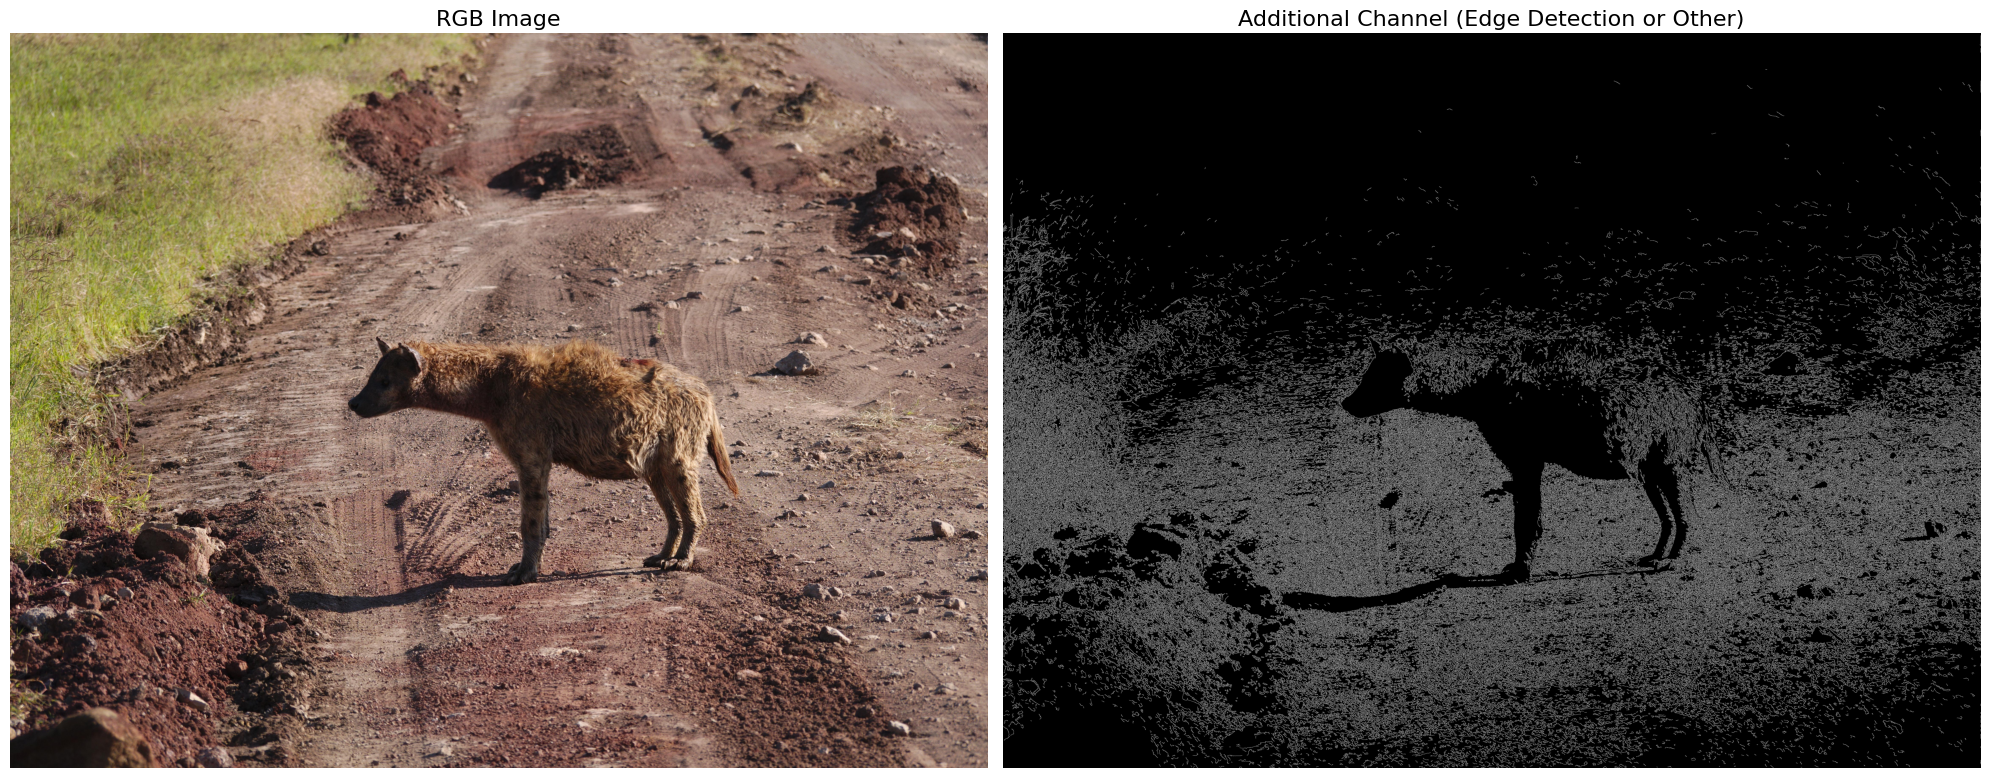

In [12]:
import os
import random
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def choose_random_image_from_folder(folder_path):
    """
    Choose a random image from the specified folder.
    Args:
        folder_path (str): Path to the folder containing images.
    """
    # Get a list of all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.tif', '.tiff'))]
    
    if not image_files:
        print(f"No image files found in {folder_path}.")
        return
    
    # Choose a random image from the list
    random_image = random.choice(image_files)
    
    # Full path to the random image
    random_image_path = os.path.join(folder_path, random_image)
    
    print(f"Randomly selected image: {random_image_path}")
    return random_image_path


def verify_image_loading_and_extraction(image_path):
    """
    Verify whether loading a multi-band image allows extraction of individual bands and additional channel (e.g., edge).
    Args:
        image_path (str): Path to the image to verify.
    """
    # Load the multi-band image using rasterio
    with rasterio.open(image_path) as src:
        image = src.read()  # Read all bands into a numpy array
        if image is None:
            print(f"Error loading image {image_path}.")
            return
        
        # Check if the image has more than 3 bands (e.g., RGB + additional channels)
        if image.shape[0] < 3:
            print(f"Image {image_path} does not have at least 3 bands (RGB).")
            return
        
        # Extract the RGB bands (first three bands)
        rgb_image = image[:3, :, :]  # First 3 bands (RGB)
        
        # Check if there is an additional channel (e.g., edge detection or other)
        if image.shape[0] > 3:
            additional_channel = image[3, :, :]  # Fourth band (edge or other)
        else:
            additional_channel = None

        # Display the images for verification
        plt.figure(figsize=(20, 15))

        # Show RGB image (first 3 channels)
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(rgb_image, (1, 2, 0)))  # Transpose to HxWxC format
        plt.title("RGB Image", fontsize=16)
        plt.axis("off")

        # Show additional channel (e.g., edge detection) if available
        if additional_channel is not None:
            plt.subplot(1, 2, 2)
            plt.imshow(additional_channel, cmap='gray')
            plt.title("Additional Channel (Edge Detection or Other)", fontsize=16)
            plt.axis("off")

        plt.tight_layout()
        plt.show()

# Example usage: specify the path to your 'combined_images' folder
combined_images_folder = 'datasets/Zoo-Animals-2/train/combined_images'  # Replace with actual path
random_image = choose_random_image_from_folder(combined_images_folder)
verify_image_loading_and_extraction(random_image)
